In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import log_loss
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier, Pool
from ngboost import NGBClassifier
from ngboost.scores import LogScore, CRPScore
from ngboost.distns import k_categorical
from sklearn.preprocessing import *
from scipy.stats import chisquare, chi2_contingency

- 2021.04.21 : 0.7343 / 0.7380 / 0.7280/ LB = 0.7208692899


### 변수 설명

< features >
    
- gender : 성별
- car: 차량 소유 여부
- reality: 부동산 소유 여부
- child_num: 자녀 수
- income_total: 연간 소득
- income_type: 소득 분류
- edu_type: 교육 수준
- family_type: 결혼 여부
- house_type: 생활 방식
- DAYS_BIRTH: 출생일
- DAYS_EMPLOYED: 업무 시작일(양수값은 고용상태가 아님)
- FLAG_MOBIL: 핸드폰 소유 여부
- work_phone: 업무용 전화 소유 여부
- phone: 전화 소유 여부
- email: 이메일 소유 여부
- occyp_type: 직업 유형													
- family_size: 가족 규모
- begin_month: 신용카드 발급 월


< target >
- credit: 사용자의 신용카드 대금 연체를 기준의 신용도

In [2]:
train = pd.read_csv('train.csv').iloc[:, 1:]
test = pd.read_csv('test.csv').iloc[:, 1:]

In [3]:
train.head(2)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0


In [4]:
test.head(2)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0


#### FLAG_MOBIL 변수는 불필요함.

In [5]:
train.drop('FLAG_MOBIL', axis = 1, inplace = True)
test.drop('FLAG_MOBIL', axis = 1, inplace = True)

In [6]:
train['begin_month'] /= (-12)
test['begin_month'] /= (-12)

In [7]:
train.at[train[train.income_type == 'Student'].index, 'income_type'] = 'Working'
test.at[test[test.income_type == 'Student'].index, 'income_type'] = 'Working'

In [8]:
train.at[train[train.DAYS_EMPLOYED > 20000].index, 'occyp_type'] = 'No job'
test.at[test[test.DAYS_EMPLOYED > 20000].index, 'occyp_type'] = 'No job'

In [159]:
#train.DAYS_EMPLOYED = [0 if x > 500 else x for x in train.DAYS_EMPLOYED]
#test.DAYS_EMPLOYED = [0 if x > 500 else x for x in test.DAYS_EMPLOYED]

In [9]:
train[['DAYS_BIRTH', 'DAYS_EMPLOYED']] /= (-365)
test[['DAYS_BIRTH', 'DAYS_EMPLOYED']] /= (-365)

In [10]:
train.fillna('Unknown', inplace = True)
test.fillna('Unknown', inplace = True)

In [12]:
train.income_type = ['Working' if x == 'Student' else x for x in train.income_type]
test.income_type = ['Working' if x == 'Student' else x for x in test.income_type]

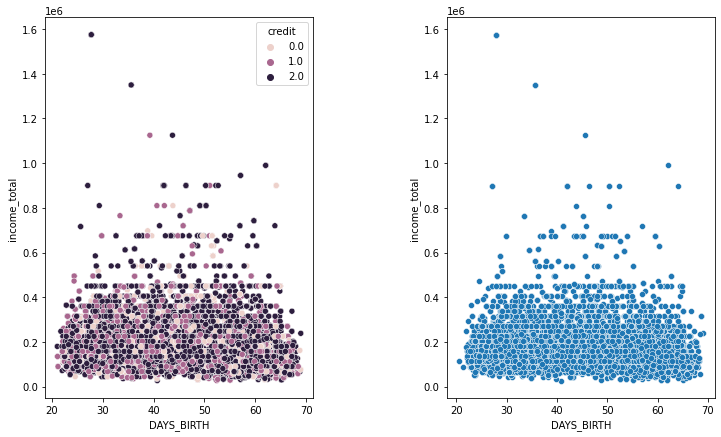

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (12, 7))
plt.subplots_adjust(wspace = .5)
sns.scatterplot(train.DAYS_BIRTH, train.income_total, hue = train.credit, ax = ax[0])
sns.scatterplot(test.DAYS_BIRTH, test.income_total, ax = ax[1])
plt.show()

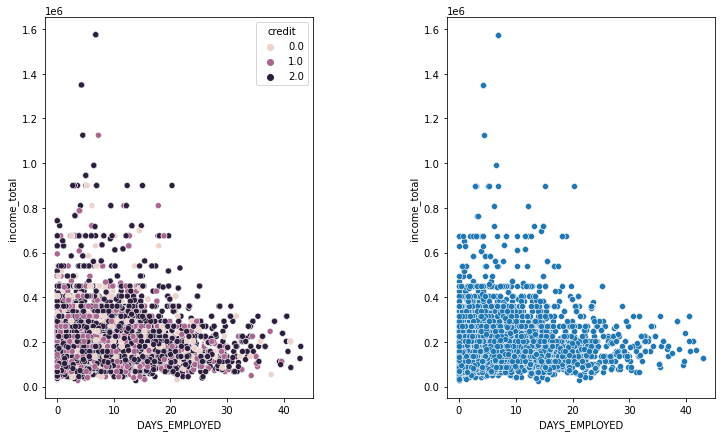

In [132]:
fig, ax = plt.subplots(1, 2, figsize = (12, 7))
plt.subplots_adjust(wspace = .5)
sns.scatterplot(train.DAYS_EMPLOYED, train.income_total, hue = train.credit, ax = ax[0])
sns.scatterplot(test.DAYS_EMPLOYED, test.income_total, ax = ax[1])
plt.show()

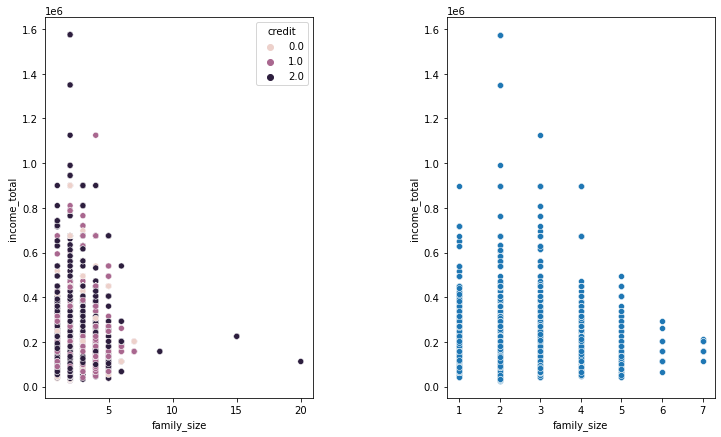

In [133]:
fig, ax = plt.subplots(1, 2, figsize = (12, 7))
plt.subplots_adjust(wspace = .5)
sns.scatterplot(train.family_size, train.income_total, hue = train.credit, ax = ax[0])
sns.scatterplot(test.family_size, test.income_total, ax = ax[1])
plt.show()

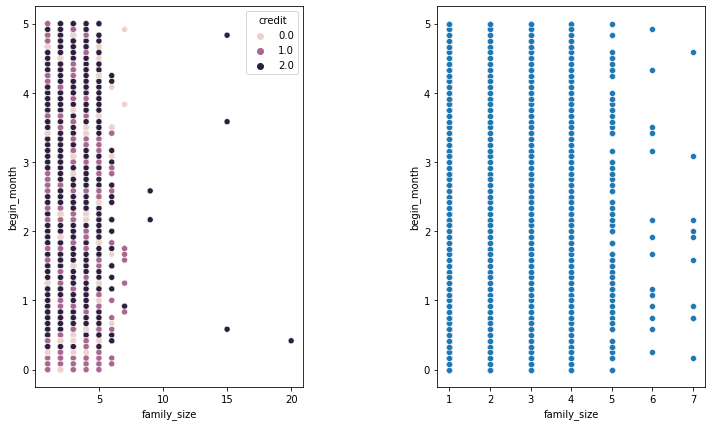

In [134]:
fig, ax = plt.subplots(1, 2, figsize = (12, 7))
plt.subplots_adjust(wspace = .5)
sns.scatterplot(train.family_size, train.begin_month, hue = train.credit, ax = ax[0])
sns.scatterplot(test.family_size, test.begin_month, ax = ax[1])
plt.show()

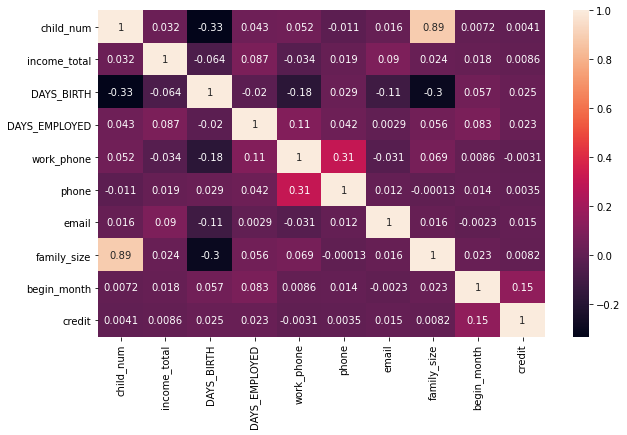

In [135]:
plt.figure(figsize = (10, 6))
sns.heatmap(train.corr(), annot = True)
plt.show()

In [136]:
#train.drop('family_size', axis = 1, inplace = True)
#test.drop('family_size', axis = 1, inplace = True)

***

In [14]:
scaler = MinMaxScaler()

In [15]:
tr_scaled = scaler.fit_transform(train[['family_size', 'child_num', 'begin_month', 'income_total', 'DAYS_BIRTH']])

In [16]:
te_scaled = scaler.transform(test[['family_size', 'child_num', 'begin_month', 'income_total', 'DAYS_BIRTH']])

In [17]:
train[['family_size', 'child_num', 'begin_month', 'income_total', 'DAYS_BIRTH']] = tr_scaled

In [18]:
test[['family_size', 'child_num', 'begin_month', 'income_total', 'DAYS_BIRTH']] = te_scaled

In [19]:
train2 = pd.get_dummies(columns = train.columns[train.dtypes == 'object'], data = train)

In [20]:
test2 = pd.get_dummies(columns = test.columns[test.dtypes == 'object'], data = test)

In [21]:
skf = StratifiedKFold(n_splits = 8, shuffle = True, random_state = 422)

In [22]:
cat_pred = np.zeros((test2.shape[0], 3))
cat_val_logloss = []
i = 0
for tr_idx, val_idx in skf.split(train2, train2.credit) :
    i += 1
    print(f'=========================={i} FOLD=========================')
    tr_x, tr_y = train2.drop('credit', axis = 1).iloc[tr_idx], train2.credit.iloc[tr_idx]
    val_x, val_y = train2.drop('credit', axis = 1).iloc[val_idx], train2.credit.iloc[val_idx]
    cat = CatBoostClassifier(iterations = 4000, early_stopping_rounds = 500, loss_function = 'MultiClass', random_state = 422, silent = True, depth = 7)
    cat.fit(tr_x, tr_y, eval_set = Pool(val_x, val_y), use_best_model = True)
    val_logloss = cat.best_score_['validation']['MultiClass']
    print(f'Logloss of Validation = {val_logloss}\n')
    cat_val_logloss.append(val_logloss)
    pred = cat.predict_proba(test2) / 8
    cat_pred += pred
print('==========================Finished!=========================\n')
print(f'평균 logloss는 {np.mean(cat_val_logloss)}')

==========================1 FOLD=========================
Logloss of Validation = 0.7277199994640043

==========================2 FOLD=========================
Logloss of Validation = 0.7330091969851587

==========================3 FOLD=========================
Logloss of Validation = 0.752403369146324

==========================4 FOLD=========================
Logloss of Validation = 0.7536901783681219

==========================5 FOLD=========================
Logloss of Validation = 0.7094103181900897

==========================6 FOLD=========================
Logloss of Validation = 0.7425067574222707

==========================7 FOLD=========================
Logloss of Validation = 0.721277343200789

==========================8 FOLD=========================
Logloss of Validation = 0.7294261019915043

==========================Finished!=========================

평균 logloss는 0.7336804080960327


In [23]:
lgb_pred = np.zeros((test2.shape[0], 3))
lgb_losses = []
i = 0
for tr_idx, val_idx in skf.split(train2, train2.credit) :
    i += 1
    print(f'========================================{i} FOLD==========================================\n')
    tr_x, tr_y = train2.drop('credit', axis = 1).iloc[tr_idx], train2.credit.iloc[tr_idx]
    val_x, val_y = train2.drop('credit', axis = 1).iloc[val_idx], train2.credit.iloc[val_idx]
    
    lgb = LGBMClassifier(n_jobs = -1, num_iterations = 1500, metric = 'multi_logloss', objective = 'multiclass', boosting_type = 'gbdt', n_estimators = 800, random_state = 413, max_depth = 6)
    
    lgb.fit(tr_x, tr_y, eval_set = [(tr_x, tr_y), (val_x, val_y)],
            early_stopping_rounds = 400, verbose = 500, eval_metric = 'multi_logloss')
    print(lgb.best_score_['valid_1']['multi_logloss'])
    lgb_losses.append(lgb.best_score_['valid_1']['multi_logloss'])
    pred = lgb.predict_proba(test2) / 8
    lgb_pred += pred
print('==========================Finished!=========================\n')
print(f'평균 logloss는 {np.mean(lgb_losses)}')

========================================1 FOLD==========================================

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 400 rounds
[500]	training's multi_logloss: 0.473112	valid_1's multi_logloss: 0.735712
Early stopping, best iteration is:
[449]	training's multi_logloss: 0.490765	valid_1's multi_logloss: 0.733958
0.7339583548871313
========================================2 FOLD==========================================

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 400 rounds
[500]	training's multi_logloss: 0.477489	valid_1's multi_logloss: 0.744821
Early stopping, best iteration is:
[386]	training's multi_logloss: 0.521206	valid_1's multi_logloss: 0.741548
0.7415484061649799
============================

In [24]:
xgb_pred = np.zeros((test2.shape[0], 3))
i = 0
xgb_losses = []
for tr_idx, val_idx in skf.split(train2, train2.credit) :
    i += 1
    print(f'=========================={i} FOLD=========================')
    tr_x, tr_y = train2.drop('credit', axis = 1).iloc[tr_idx], train2.credit.iloc[tr_idx]
    val_x, val_y = train2.drop('credit', axis = 1).iloc[val_idx], train2.credit.iloc[val_idx]
    
    xgb = XGBClassifier(n_jobs = -1, objective = 'multi:softprob', n_estimators = 750, random_state = 422, max_depth = 6)
    
    xgb.fit(tr_x, tr_y, eval_metric = 'mlogloss', eval_set = [(tr_x, tr_y), (val_x, val_y)],
            early_stopping_rounds = 250, verbose = 500)
    p = xgb.predict_proba(val_x, ntree_limit = xgb.best_iteration)
    print(log_loss(val_y, p))
    xgb_losses.append(log_loss(val_y, p))
    pred = xgb.predict_proba(test2, ntree_limit = xgb.best_iteration) / 8
    xgb_pred += pred
print('==========================Finished!=========================\n')
print(f'평균 logloss는 {np.mean(xgb_losses)}')

==========================1 FOLD=========================
[0]	validation_0-mlogloss:0.97426	validation_1-mlogloss:0.97750
[497]	validation_0-mlogloss:0.29138	validation_1-mlogloss:0.75569
0.7243320532091032
==========================2 FOLD=========================
[0]	validation_0-mlogloss:0.97393	validation_1-mlogloss:0.97874
[429]	validation_0-mlogloss:0.31832	validation_1-mlogloss:0.75545
0.7303225816972948
==========================3 FOLD=========================
[0]	validation_0-mlogloss:0.97399	validation_1-mlogloss:0.97971
[482]	validation_0-mlogloss:0.30095	validation_1-mlogloss:0.76172
0.7387816896615649
==========================4 FOLD=========================
[0]	validation_0-mlogloss:0.97411	validation_1-mlogloss:0.98093
[435]	validation_0-mlogloss:0.31577	validation_1-mlogloss:0.76301
0.7373729324678541
==========================5 FOLD=========================
[0]	validation_0-mlogloss:0.97525	validation_1-mlogloss:0.97510
[451]	validation_0-mlogloss:0.30631	validation_1-m

0.7409 / 0.7412 / 0.72985

In [25]:
submission = pd.read_csv('sample_submission.csv')

In [31]:
submission.iloc[:, 1:] = xgb_pred * 0.4 + lgb_pred * 0.25 + cat_pred * .35

In [32]:
submission

,index,0,1,2
0,26457,0.043251,0.081236,0.875513
1,26458,0.211893,0.161910,0.626197
2,26459,0.057776,0.110464,0.831760
3,26460,0.155610,0.112401,0.731989
4,26461,0.065330,0.154730,0.779940
...,...,...,...,...
9995,36452,0.215564,0.208694,0.575742
9996,36453,0.193742,0.312571,0.493687
9997,36454,0.012356,0.053884,0.933759
9998,36455,0.082388,0.222943,0.694669


In [33]:
submission.to_csv('0419submission.csv', index = False)

0.7199225804